# Support Vector Machines (SVMs)

# Introduction

[Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) algorithm is a powerful supervised machine learning algorithm, which can perform both regression and classification problems. 

There are two types of SVM, linear SVM (simple SVM) and non-linear SVM (kernel SVM). Linear SVM is used for linearly separable data, while the non-linear SVM is used for non-linearly separated data.

SVM creates the best decision boundary between separate classes. To achieve the goal, it finds the maximum distance from the nearest points of two classes, and this optimal decision boundary is called support vectors. The region between the decision boundary defined by support vectors is margin.
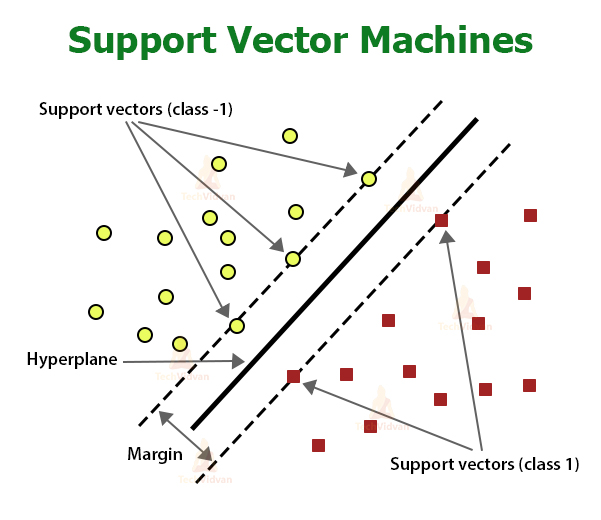

### Generalized Algorithm:
- Plot each data point in an N-dimensional space, where N is the number of features/attributes in the data
- Find the optimal hyperplane to separate the data
  - Use the **support vectors** to do this. Support vectors are data points closer to the hyperplane that influence the position and orientation of the hyperplane - we can use these support vectors to maximize the margin of the classifier. Deleting them changes the position of the hyperplane.

![image](https://miro.medium.com/max/1050/0*ecA4Ls8kBYSM5nza.jpg)

- Weights update function (using gradients)

![image](https://miro.medium.com/max/1050/1*WUphtYLfTOAoaXQXvImBeA.png)

which becomes

![image](https://miro.medium.com/max/462/1*-nKEXrWos8Iuf-DWSv_srQ.png)

for when there is *no misclassification* (i.e. our model correctly predicts the class of our data points, so we only have to update the gradient from the regularization parameter), and 

![image](https://miro.medium.com/max/642/1*tnvMhAKaTUCO43diEvtTAQ.png)

when there has been a *misclassification* (i.e. the model made a mistake on the prediction of the class of a datapoint, so we need to include the loss along with the regularization parameter to perform the gradient update).

- Take the output of the linear function: if the output is larger than 1, we identify it with one class, if the output is -1, we identify it with another class. 

Cost function: our goal is to maximize the margin between datapoints and the hyperplane, so we use hinge loss (below: piecewise function (left), function (right))

![image](https://miro.medium.com/max/1624/1*hHlytjVk6d7O2WWvG2Gdig.png)

Final cost function:

![image](https://miro.medium.com/max/1400/1*GQAd28bK8LKOL2kOOFY-tg.png)

**Kernelized SVM**

This method allows a nonlinear function to separate the dataset. It maps each datapoint into a higher dimension, exemplified below:

![image](https://miro.medium.com/max/1400/1*ZpkLQf2FNfzfH4HXeMw4MQ.png)

- kernel: measure of similarity between datapoints
- kernel function: reveals the similarity between two datapoints in the newly transformed feature space. There are a few kernel function options:
  - **Redial Basis Function Kernel (RBF):** The similariy between two points in the transformed feature space is an exponentially decaying function of the distance between the vectors and the original input space. RBF is the default kernel used in SVM

![image](https://user-images.githubusercontent.com/89811204/146305418-93423376-1086-4f5f-a0e9-9c099d7c3132.png)

  - **Polynomial Kernel:** takes an additional parameter, "degree" that controls the model's complexity and computational cost of the transformation
  - **Kernel Trick:** the actual transformation of points to the new high dimensional space is not always necessary. Though the trick itself is quite complex, simply explained, the kernelized SVM can internally compute these complex transformations just in terms of similarity calculations between pairs of points in the higher dimensional feature space where the transformed feature representation is implicit. This similarity function, which is mathematically a kind of complex dot product is actually the kernel of a kernelized SVM. This makes it practical to apply SVM, when the underlying feature space is complex, or even infinite-dimensional.

For more information refer to [this article](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47).


---

## Implementation

This notebook illustrate the implementation of SVM to train a classifier to automatically annotate single-cell RNA-seq data. The training data is an expert-annotated dataset. 

### About the Dataset

The Processed 3k Peripheral Blood Mononuclear Cells (PBMCs) Dataset consists of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. 

### Tools

The following libraries are used in the notebook:

* [matplotlib](http://metplotlib.org)
* [pandas](http://pandas.pydata.org)
* [numpy](https://numpy.org/doc/stable/index.html)
* [seaborn](https://seaborn.pydata.org/)
* [scanpy](https://scanpy.readthedocs.io/en/stable/)
* [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) in [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC) in [sklearn.svm](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html?highlight=calibratedclassifiercv#sklearn.calibration.CalibratedClassifierCV) in [sklearn.calibration](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.calibration)
* [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix) in [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) in [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [scipy.sparse.linalg](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html)

The [Processed 3k PBMCs](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k_processed.html) Dataset is loaded from [scanpy.datasets](https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.datasets).

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import scipy.sparse.linalg

### Data Exploration

The data used in the notebook is publicly available in scanpy package (the most popular single-cell framework in python). This dataset contains over 2000 human peripheral blood mononuclear cells.

In [4]:
adata = sc.datasets.pbmc3k_processed().raw.to_adata()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [5]:
# print to see the data structure
print(adata)

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'


Let's take a look at meta data for the observes (cells).
The louvain column is the cell annotation (expert annotated from louvain clustering results).

In [6]:
adata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells


The objective is to an SVM classifier to automatically annotate cells. Single-cell data is sparse and has many features (usually 10-20k), so we need to do dimensional reductions first (PCA).
We also want to perform PCA with a relatively small set of genes, e.g. 2000.
Here, we use the built-in function of scanpy to compute top_n variable genes

In [7]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
# We then only focus on these 2000 features (genes)
adata = adata[:, adata.var.highly_variable]

In [8]:
# Get the predictors (genes here; we will then do PCA)
X = adata.X
# The targets
Y = adata.obs['louvain']
Y.to_numpy()
# Split the training and testing set
X_train,X_val,y_train,y_val = train_test_split(X,Y,test_size=0.3, stratify=Y)

### Algorithm Implementation

In [9]:
# define a pca function
# pca for sparse matrix; modified from https://gist.github.com/julienr/8096321
def pca_sparse(X, npc):
    n_samples, n_features = X.shape
    Xmean = np.mean(X, axis=0)
    U, s, Vt = scipy.sparse.linalg.svds(X - Xmean, k=npc)
    order = np.argsort(-s) # sort s in descending order

    # svds returns U, s, Vt sorder in ascending order. We want descending
    s = s[order]
    W = Vt[order,:]
    U = U[:, order]

    explained_variance = (s**2) / float(n_samples)
    exp_var_ratio = explained_variance / explained_variance.sum()

    return U, s, W, exp_var_ratio

In [10]:
# do PCA with 50 dims
p = pca_sparse(X=X_train, npc=50)
# 
V = p[2].T
Us = np.matmul(p[0], np.diag(p[1]))
exp_var_thresh = 0.01
Us_sig = Us[:, p[3] > exp_var_thresh]

In [11]:
# check dimensions of Us_sig and V matrices; here we see top 8 dimensions can explain over 99% of variance
print(Us_sig.shape)
print(V.shape)

(1846, 8)
(2000, 50)


In [12]:
# project X_val to the same space
# get projection matrix
V_sig = V[:, p[3] > exp_var_thresh]
# center X_val
X_val_mean = np.mean(X_val, axis=0)
X_val_c = X_val - X_val_mean
# projection
X_val_p = np.matmul(X_val_c, V_sig)

In [13]:
# train
Classifier = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovr')
clf = CalibratedClassifierCV(Classifier)
clf.fit(Us_sig, y_train)

CalibratedClassifierCV(base_estimator=SVC())

In [14]:
# predict
predicted = clf.predict(X_val_p)
# compute probability
prob = np.max(clf.predict_proba(X_val_p), axis = 1)
# label the cells with ambiguous prediction as 'Unknown'
# ambiguous means its max prediction probability is less than a threshold; used 0.5 here
unlabeled = np.where(prob < 0.5)
predicted[unlabeled] = 'Unknown'

c:\Users\ppraveen\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\ppraveen\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\ppraveen\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\ppraveen\Anacond

### Build the confusion matrix

In [15]:
x_actual = pd.Series(y_val.to_numpy(), name='Actual')
x_predicted = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(x_actual, x_predicted)

### Visualization

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

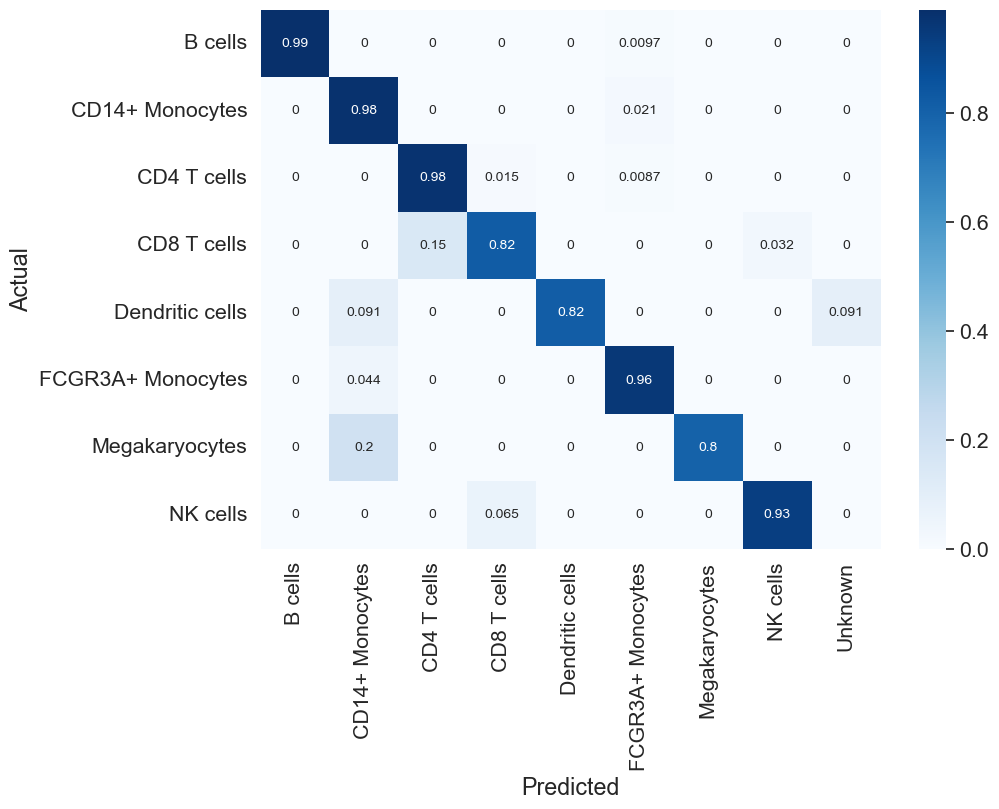

In [16]:
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_confusion.div(df_confusion.sum(axis=1), axis=0), cmap="Blues", annot=True,annot_kws={"size": 10})